## Modeling key contributors to electricity prices in MISO

In this notebook, I use a variety of machine learning techniques to predict the wind offer price

In [366]:
#Import necessary libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy as sp
import pandas as pd

import statsmodels.api as sm

import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn import metrics, tree, ensemble, cross_validation, grid_search
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.linear_model import LogisticRegression

%matplotlib inline


In [3]:
#import scrubbed data
base_path = r'C:\Users\jhensley\Desktop\GA_Data_Science\DS-DC-16\projects\final-projects\data\\'
miso = pd.DataFrame.from_csv(base_path + 'miso.csv')

In [313]:
#Get all offer price and capacity features
prices = miso.columns[miso.columns.str.contains('wavg')==True]
prices =prices.drop(['Run of River wavg_price', 'Wind wavg_price', 'Combined Cycle Aggregate wavg_price'])

caps = miso.columns[miso.columns.str.contains('Economic')==True]
caps = caps.drop(['Run of River Economic Max', 'Run of River Economic Min'])

In [425]:
#Define feature columns
feature_columns = [
'actual_load',
'forecast_load',
'forecast_error',
'coal',
'gas',
'hydro',
'nuclear',
'wind',
'other',
'hh_price',
'Peak',
'hour',
'month',
'LMP'
]

#Add pricing features
feature_columns.extend(prices)
feature_columns.extend(caps)

In [426]:
#First set of modeling techniques will not consider time element of data.
#Randomize data rows to eliminater serialized data
miso_rand = miso.sample(frac=1).reset_index()

In [427]:
#Add time variables
miso_rand['month'] = miso_rand.timestamp.dt.month
miso_rand['hour'] = miso_rand.timestamp.dt.hour

## Split data into training and testing sets

In [428]:
#Create features and response
X = miso_rand[feature_columns]
y = miso_rand['Wind wavg_price']

#Train, test, split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, random_state=7)

## Random Forests

Begin with Random Forests to identify feature importance

In [432]:
# import class, instantiate estimator, fit with all data
rf = ensemble.RandomForestRegressor(n_estimators=20, random_state=1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print rf.score(X, y)
print metrics.mean_squared_error(y_test, y_pred_rf)**0.5

0.98953119627
0.554796407018


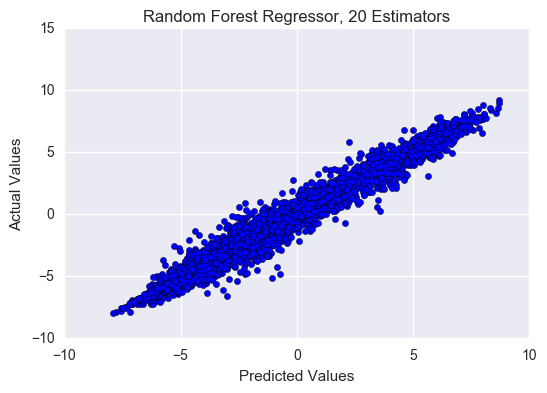

In [431]:
#Plot predictions against actuals
plt.scatter(y_pred_rf, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Random Forest Regressor, 20 Estimators')

In [413]:
#Identify top 10 feature importance
Feat_Importance = pd.DataFrame({'feature':feature_columns, 'importance':rf.feature_importances_})
Feat_Importance.sort_values('importance', ascending=False)[0:15]

,feature,importance
15,All Diesel Units wavg_price,0.469652
37,Wind Economic Max,0.331934
50,Wind Economic Min,0.030350
21,Other Fossil wavg_price,0.009977
22,Other Peaker wavg_price,0.008980
6,nuclear,0.008552
36,Steam Turbine Economic Max,0.007428
35,Pumped Storage Economic Max,0.007146
34,Other Peaker Economic Max,0.007023
17,Combined Cycle CT wavg_price,0.006993


## Linear Regression

In [325]:
#Use a linear regression to model electricity prices
#Begin with sklearn

model = LinearRegression()
results = model.fit(X_train, y_train)

score = results.score(X,y)
print "Score: " + str(score)

y_pred_lm = results.predict(X_test)

rmse = (metrics.mean_squared_error(y_test, y_pred_lm))**.5
print "RMSE: " + str(rmse)

Score: 0.766645624761
RMSE: 1.60923473872


In [326]:
#Now model with statsmodels
model_sm = sm.OLS(y_train, X_train )
results_sm = model_sm.fit()

#Print Summary
results_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Wind wavg_price   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     1534.
Date:                Tue, 20 Dec 2016   Prob (F-statistic):               0.00
Time:                        16:06:18   Log-Likelihood:                -41097.
No. Observations:               21574   AIC:                         8.229e+04
Df Residuals:                   21527   BIC:                         8.266e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------
actual_load                           -2.012e-05   2.78e-06     -7.229      0.000     -2.56e-05 -1.47e-05
forecast_load                         -5.685e-06   2.13e-06     -2.672      0.008     -9.86e-06 -1.51e-06
forecast_error                         1.444e-05   3.36e-06      4.297      0.000      7.85e-06   2.1e-05
coal                                  -2.959e-05   4.75e-06     -6.235      0.000     -3.89e-05 -2.03e-05
gas                                    7.884e-05   5.55e-06     14.219      0.000       6.8e-05  8.97e-05
hydro                                     0.0002   3.45e-05      4.555      0.000      8.95e-05     0.000
nuclear                                   0.0001   1.63e-05      6.669      0.000      7.67e-05     0.000
wind                                   4.166e-06   7.12e-06      0.585      0.559     -9.79e-06  1.81e-05
other                                  1.715e-05   1.63e-05      1.054      0.292     -1.48e-05  4.91e-05
hh_price                                  0.5916      0.047     12.595      0.000         0.500     0.684
Peak                                     -0.2371      0.039     -6.002      0.000        -0.314    -0.160
hour                                      0.0157      0.002      7.262      0.000         0.011     0.020
month                                    -0.2854      0.006    -48.054      0.000        -0.297    -0.274
LMP                                      -0.0024      0.001     -3.586      0.000        -0.004    -0.001
90 wavg_price                          1.804e-14   1.54e-14      1.168      0.243     -1.22e-14  4.83e-14
All Diesel Units wavg_price               0.0714      0.001     49.530      0.000         0.069     0.074
Combine Cycle ST wavg_price              -0.0003      0.001     -0.481      0.631        -0.001     0.001
Combined Cycle CT wavg_price             -0.0021      0.001     -1.743      0.081        -0.004     0.000
Combustion Turbine wavg_price             0.0200      0.003      6.214      0.000         0.014     0.026
DR Type1 wavg_price                    7.195e-15   7.23e-16      9.947      0.000      5.78e-15  8.61e-15
DR Type2 wavg_price                      -0.0087      0.001     -9.220      0.000        -0.011    -0.007
Other Fossil wavg_price                   0.0777      0.007     10.897      0.000         0.064     0.092
Other Peaker wavg_price                   0.0086      0.001      6.415      0.000         0.006     0.011
Pumped Storage wavg_price                -0.0106      0.001    -10.445      0.000        -0.013    -0.009
Steam Turbine wavg_price                 -0.1295      0.020     -6.559      0.000        -0.168    -0.091
90 Economic Max                           0.3113      0.112      2.788      0.005         0.092     0.530
All Diese

## Ridge Regression


In [406]:
alpha_range = 10.**np.arange(-15,15)
rrcv = RidgeCV(normalize=True, scoring='mean_squared_error', alphas=alpha_range)
rrcv.fit(X_train, y_train)

preds = rrcv.predict(X_test)

print 'RMSE: ', metrics.mean_squared_error(y_test, preds)**0.5

print 'Score: ', rrcv.score(X,y)

print zip(feature_columns, rrcv.coef_)

RMSE:  1.70438143129
Score:  0.739891534464
[('actual_load', -1.8373542283831831e-05), ('forecast_load', -1.7894472378326629e-05), ('forecast_error', 2.3628891251545142e-05), ('coal', -2.3987177843621702e-05), ('gas', 8.6135104749991803e-05), ('hydro', 0.00036053330878618717), ('nuclear', 3.2087951114085839e-05), ('wind', 9.1350368582900269e-06), ('other', -0.00013898273723428719), ('hh_price', 0.91301769179661396), ('Peak', -0.049499251339874227), ('LMP', -0.0020639343778643148), ('90 wavg_price', 0.0), ('All Diesel Units wavg_price', 0.068916661843748048), ('Combine Cycle ST wavg_price', 0.0021533353336556445), ('Combined Cycle CT wavg_price', -0.0024943897081264963), ('Combustion Turbine wavg_price', 0.014946093135077016), ('DR Type1 wavg_price', 0.0), ('DR Type2 wavg_price', -0.014794306573295212), ('Other Fossil wavg_price', 0.04276828446566748), ('Other Peaker wavg_price', 0.017929781343990134), ('Pumped Storage wavg_price', -0.0061946572381121274), ('Steam Turbine wavg_price', -

## Lasso Regression

In [407]:
lscv = LassoCV(normalize=True, alphas=alpha_range)
lscv.fit(X_train, y_train)

print 'RMSE: ', metrics.mean_squared_error(y_test, preds)**0.5

print 'Score: ', lscv.score(X,y)

print zip(feature_columns, lscv.coef_)

RMSE:  1.70438143129
Score:  0.739763928241
[('actual_load', -3.6821835038743574e-05), ('forecast_load', 2.0231186939890746e-07), ('forecast_error', 5.6319926512703223e-06), ('coal', -2.3195507872829374e-05), ('gas', 8.5607961210266704e-05), ('hydro', 0.00035676942020519421), ('nuclear', 2.9306314002345281e-05), ('wind', 9.4352888397515164e-06), ('other', -0.00013682594938613932), ('hh_price', 0.908981600889191), ('Peak', -0.039313272440827336), ('LMP', -0.0020173390346469541), ('90 wavg_price', 0.0), ('All Diesel Units wavg_price', 0.069042367764929849), ('Combine Cycle ST wavg_price', 0.00060998055406537354), ('Combined Cycle CT wavg_price', -0.002078730641703456), ('Combustion Turbine wavg_price', 0.013837695132144926), ('DR Type1 wavg_price', 0.0), ('DR Type2 wavg_price', -0.01489855652772447), ('Other Fossil wavg_price', 0.044330814737353882), ('Other Peaker wavg_price', 0.017766952605463911), ('Pumped Storage wavg_price', -0.0060620160456515042), ('Steam Turbine wavg_price', -0.1

## Time Series Analysis

Treat data as a time series

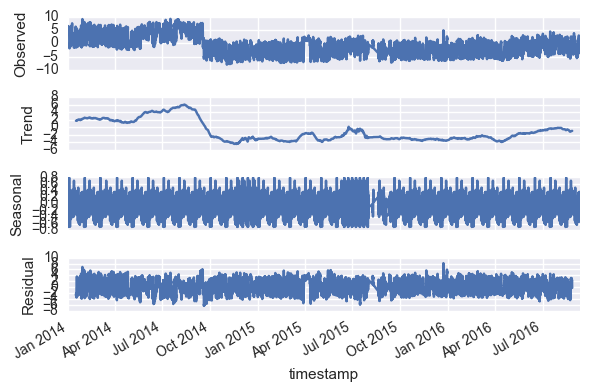

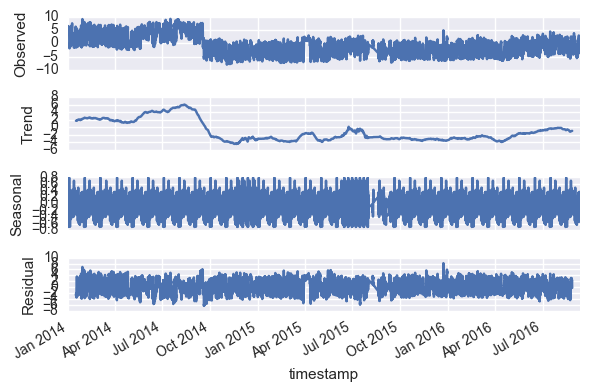

In [341]:
#Seasonal Trend Decomposition
wind = miso['Wind wavg_price']
wind_dec = sm.tsa.seasonal_decompose(wind, model = 'Additive', freq=24*30)
wind_dec.plot()

In [408]:
#reset feature columns
#Define feature columns
feature_columns = [
'actual_load',
'forecast_load',
'forecast_error',
'coal',
'gas',
'hydro',
'nuclear',
'wind',
'other',
'hh_price',
'Peak',
'LMP'
]

#Add pricing features
feature_columns.extend(prices)
feature_columns.extend(caps)

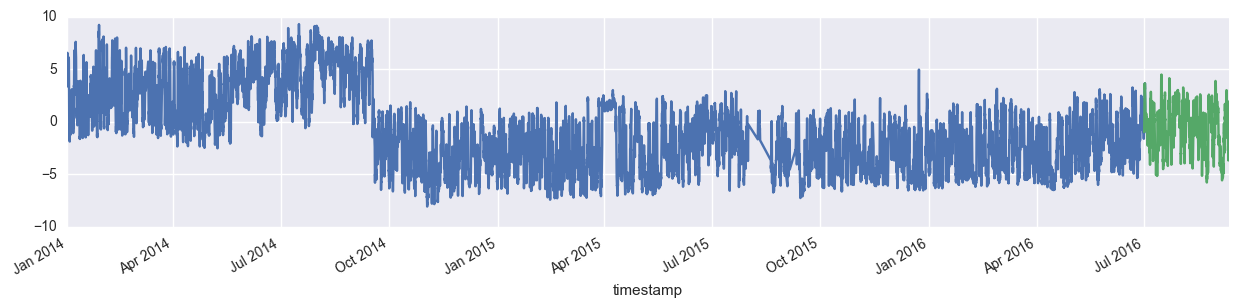

In [409]:
#Train, test, split
X = miso[feature_columns]
y = miso['Wind wavg_price']

X_train = X[:'20160701']
y_train = y[: '20160701']
X_test = X['20160701':]
y_test = y['20160701':]

#Plot training data
y_train.plot(figsize=(15,3))
y_test.plot(figsize=(15,3))

In [410]:
#ARMA Model

arma_model = sm.tsa.ARMA(endog=y_train, exog=X_train,  order=(0,1), freq='H').fit(method='css')
arma_model.summary2() 


ValueError: could not broadcast input array from shape (49) into shape (50)